In [2]:
import tensorflow as tf
print(dir(tf.keras.applications))


['ConvNeXtBase', 'ConvNeXtLarge', 'ConvNeXtSmall', 'ConvNeXtTiny', 'ConvNeXtXLarge', 'DenseNet121', 'DenseNet169', 'DenseNet201', 'EfficientNetB0', 'EfficientNetB1', 'EfficientNetB2', 'EfficientNetB3', 'EfficientNetB4', 'EfficientNetB5', 'EfficientNetB6', 'EfficientNetB7', 'EfficientNetV2B0', 'EfficientNetV2B1', 'EfficientNetV2B2', 'EfficientNetV2B3', 'EfficientNetV2L', 'EfficientNetV2M', 'EfficientNetV2S', 'InceptionResNetV2', 'InceptionV3', 'MobileNet', 'MobileNetV2', 'MobileNetV3Large', 'MobileNetV3Small', 'NASNetLarge', 'NASNetMobile', 'ResNet101', 'ResNet101V2', 'ResNet152', 'ResNet152V2', 'ResNet50', 'ResNet50V2', 'VGG16', 'VGG19', 'Xception', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'convnext', 'densenet', 'efficientnet', 'efficientnet_v2', 'imagenet_utils', 'inception_resnet_v2', 'inception_v3', 'mobilenet', 'mobilenet_v2', 'mobilenet_v3', 'nasnet', 'resnet', 'resnet50', 'resnet_v2', 'vgg16', 'vgg19', 

_____________________________________________________ Last version __________________________________________________

In [26]:
!pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org timm

   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.4 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.4 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.4 MB ? eta -:--:--
   -------- ------------------------------- 0.5/2.4 MB 409.6 kB/s eta 0:00:05
   ------------- -------------------------- 0.8/2.4 MB 559.5 kB/s eta 0:00:03
   ------------- -------------------------- 0.8/2.4 MB 559.5 kB/s eta 0:00:03
   ----------------- ---------------------- 1.0/2.4 MB 637.3 kB/s eta 0:00:03
   ---------------------- ----------------- 1.3/2.4 MB 699.0 kB/s eta 0:00:02
   -------------------------- ------------- 1.6/2.4 MB 729.4 kB/s eta 0:00:02
   ------------------------------- -------- 1.8/2.4 MB 756.9 kB/s eta 0:00:01
   ------------------------------- -------- 1.8/2.4 MB 756.9 kB/s eta 0:00:01
   ----------------------------

In [22]:
import os
import numpy as np
import cv2
import timm
from tensorflow.keras.applications import DenseNet201, InceptionV3, Xception, ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import torch
from torch.nn.functional import adaptive_avg_pool2d
import tensorflow as tf



In [2]:
# Paths
data_dir = "./wheat_disease"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

In [3]:
# Hyperparameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 1e-6
PATIENCE = 2
FACTOR = 0.5
MONITOR = "val_loss"
SAVE_BEST_ONLY = True
MODE = "min"
OPTIMIZER = Adam(learning_rate=LEARNING_RATE)
LOSS = "categorical_crossentropy"

# CLAHE Preprocessing
def apply_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

# Load and preprocess dataset
def load_data(data_dir, apply_clahe_flag=False):
    images, labels = [], []
    for label, class_dir in enumerate(os.listdir(data_dir)):
        class_path = os.path.join(data_dir, class_dir)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_CUBIC)
            if apply_clahe_flag:
                img = apply_clahe(img)
            images.append(img / 255.0)  # Min-Max Normalization
            labels.append(label)
    return np.array(images), np.array(labels)



In [4]:
# Load data
X_train_original, y_train_original = load_data(train_dir, apply_clahe_flag=False)
X_train_clahe, y_train_clahe = load_data(train_dir, apply_clahe_flag=True)
X_test, y_test = load_data(test_dir)

In [5]:
# Combine original and CLAHE datasets
X_train_combined = np.concatenate([X_train_original, X_train_clahe], axis=0)
y_train_combined = np.concatenate([y_train_original, y_train_clahe], axis=0)


In [6]:
# One-hot encode labels
y_train_combined = to_categorical(y_train_combined)
y_test = to_categorical(y_test)


In [7]:
# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_train_combined, y_train_combined, test_size=0.3, random_state=42)


In [8]:
# Define feature extraction models
def create_model(base_model, input_shape):
    base = base_model(weights="imagenet", include_top=False, input_tensor=Input(shape=input_shape))
    x = GlobalAveragePooling2D()(base.output)
    return Model(inputs=base.input, outputs=x)



In [9]:
input_shape = (224, 224, 3)
model_dense201 = create_model(DenseNet201, input_shape)
model_incepv3 = create_model(InceptionV3, input_shape)
model_xception = create_model(Xception, input_shape)


In [23]:
model_ResNet50V2 =create_model(ResNet50V2, input_shape)

In [19]:
import timm
import torch

def extract_regnet_features(images):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Remove `trust_host` argument
    model = timm.create_model('regnety_080', pretrained=True)
    model.eval()
    model.to(device)
    # Process images and extract features here (assuming appropriate pre-processing is done)
    return model

# Feature extraction in batches
def extract_features_in_batches(model, data, batch_size=32):
    features = []
    for start in range(0, len(data), batch_size):
        end = start + batch_size
        batch_data = data[start:end]
        batch_tensor = tf.convert_to_tensor(batch_data, dtype=tf.float32)
        batch_features = model.predict(batch_tensor)  # Updated to use .predict()
        features.append(batch_features)
    return np.vstack(features)



In [11]:
# Extract features for training
features_dense201 = extract_features_in_batches(model_dense201, X_train, batch_size=BATCH_SIZE)
features_incepv3 = extract_features_in_batches(model_incepv3, X_train, batch_size=BATCH_SIZE)
features_xception = extract_features_in_batches(model_xception, X_train, batch_size=BATCH_SIZE)


D:\anaconda\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3

D:\anaconda\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


D:\anaconda\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_708']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

D:\anaconda\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_708']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


D:\anaconda\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1020']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 

D:\anaconda\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1020']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


OSError: Could not find a suitable TLS CA certificate bundle, invalid path: C:\Program Files\PostgreSQL\16\ssl\certs\ca-bundle.crt

In [24]:
features_ResNet50V2 = extract_features_in_batches(model_ResNet50V2, X_train, batch_size=BATCH_SIZE)

D:\anaconda\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1153']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

D:\anaconda\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1153']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [25]:
# Combine extracted features
X_train_features = np.concatenate([features_dense201, features_incepv3, features_xception, features_ResNet50V2], axis=1)


In [26]:
# Extract features for validation
features_dense201_val = extract_features_in_batches(model_dense201, X_val, batch_size=BATCH_SIZE)
features_incepv3_val = extract_features_in_batches(model_incepv3, X_val, batch_size=BATCH_SIZE)
features_xception_val = extract_features_in_batches(model_xception, X_val, batch_size=BATCH_SIZE)




1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 

OSError: Could not find a suitable TLS CA certificate bundle, invalid path: C:\Program Files\PostgreSQL\16\ssl\certs\ca-bundle.crt

In [28]:
features_ResNet50V2_val = extract_features_in_batches(model_ResNet50V2, X_val, batch_size=BATCH_SIZE)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [29]:
X_val_features = np.concatenate([features_dense201_val, features_incepv3_val, features_xception_val, features_ResNet50V2_val], axis=1)


In [30]:
# Extract features for testing
features_dense201_test = extract_features_in_batches(model_dense201, X_test, batch_size=BATCH_SIZE)
features_incepv3_test = extract_features_in_batches(model_incepv3, X_test, batch_size=BATCH_SIZE)
features_xception_test = extract_features_in_batches(model_xception, X_test, batch_size=BATCH_SIZE)
features_ResNet50V2_test = extract_features_in_batches(model_ResNet50V2, X_test, batch_size=BATCH_SIZE)



1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [31]:
X_test_features = np.concatenate([features_dense201_test, features_incepv3_test, features_xception_test, features_ResNet50V2_test], axis=1)


In [32]:
# Ensemble learning
rf = RandomForestClassifier(n_estimators=50, max_features="log2", class_weight="balanced", random_state=1, min_samples_leaf=2, min_samples_split=5, bootstrap=True, criterion="gini", oob_score=True)
dt = DecisionTreeClassifier(max_depth=200, class_weight="balanced", random_state=0, min_samples_leaf=1, min_samples_split=2, criterion="gini", splitter="best", ccp_alpha=0.2, min_impurity_decrease=0.2)
svm = SVC(kernel="rbf", C=10, gamma=0.0001, class_weight="balanced", probability=True, tol=0.001, cache_size=256, max_iter=-1, decision_function_shape="ovr", break_ties=True)


In [33]:

ensemble_model = VotingClassifier(estimators=[("RF", rf), ("DT", dt), ("SVM", svm)], voting="hard", weights=[1, 2, 3], n_jobs=-1, verbose=2, flatten_transform=True)



In [34]:
# Train ensemble model
ensemble_model.fit(X_train_features, np.argmax(y_train, axis=1))



VotingClassifier(estimators=[('RF',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_features='log2',
                                                     min_samples_leaf=2,
                                                     min_samples_split=5,
                                                     n_estimators=50,
                                                     oob_score=True,
                                                     random_state=1)),
                             ('DT',
                              DecisionTreeClassifier(ccp_alpha=0.2,
                                                     class_weight='balanced',
                                                     max_depth=200,
                                                     min_impurity_decrease=0.2,
                                                     random_state=0)),
                             ('SVM',
                              SVC(C=10, break_ties=True, cache_size=256,
                                  class_weight='balanced', gamma=0.0001,
                                  probability=True))],
                 n_jobs=-1, verbose=2, weights=[1, 2, 3])

In [37]:
# Validate ensemble model
y_val_pred = ensemble_model.predict(X_val_features)



In [38]:
val_acc = accuracy_score(np.argmax(y_val, axis=1), y_val_pred)
print(f"Validation Accuracy: {val_acc}")


Validation Accuracy: 0.9977349943374858


In [42]:
# Test ensemble model
y_test_pred = ensemble_model.predict(X_test_features)
print(classification_report(np.argmax(y_test, axis=1), y_test_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       226
           1       1.00      1.00      1.00       279
           2       1.00      0.99      0.99       232

    accuracy                           0.99       737
   macro avg       0.99      0.99      0.99       737
weighted avg       0.99      0.99      0.99       737



In [62]:
# Test a single image
def test_single_image(image_path, models, ensemble_model):
    # Load and preprocess the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image at {image_path} could not be loaded. Please check the path or file.")
    img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_CUBIC)
    img = img / 255.0  # Min-Max Normalization
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Extract features using the models
    features = []
    for model in models:
        features.append(model.predict(img))
    features_combined = np.concatenate(features, axis=1)

    # Predict using the ensemble model
    return ensemble_model.predict(features_combined)


# Define the list of feature extraction models
feature_extraction_models = [model_dense201, model_incepv3, model_xception, model_ResNet50V2]

# Path to the single test image
image_path = "./test.jpg"

# Predict the class for the single image
predicted_class = test_single_image(image_path, feature_extraction_models, ensemble_model)
print(f"Predicted Class for the image {image_path}: {predicted_class[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Predicted Class for the image ./test.jpg: 2


In [63]:
# Calculate test accuracy
test_accuracy = accuracy_score(np.argmax(y_test, axis=1), y_test_pred)
print(f"Test Accuracy: {test_accuracy}")



Test Accuracy: 0.994572591587517


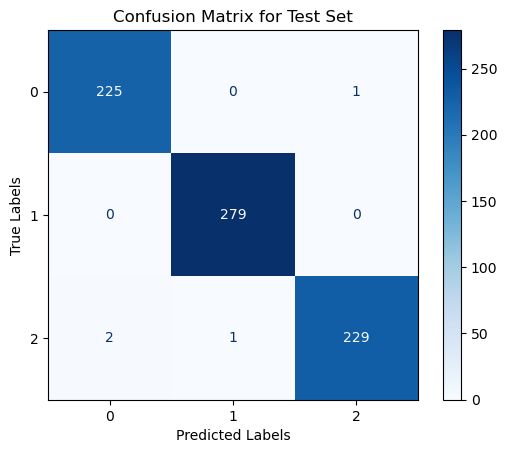

In [65]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Generate confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_test_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(np.argmax(y_test, axis=1)))
disp.plot(cmap="Blues")
disp.ax_.set_title("Confusion Matrix for Test Set")
disp.ax_.set_xlabel("Predicted Labels")
disp.ax_.set_ylabel("True Labels")
plt.show()
